# Kaggle : New York City Taxi Trip Duration
### Share code and data to improve ride time predictions

https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels

## 1. EDA (Exploratory Data Analysis)

### a. understanding data 

In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns
from ipyleaflet import *
from math import sin, cos, sqrt, atan2, radians
import folium
import folium.plugins as plugins
import os
from folium.plugins import MarkerCluster     # Map
from geographiclib.geodesic import Geodesic  # Map
import time, datetime                        # time data
import calendar
import scipy


%matplotlib inline

In [2]:
train = pd.read_csv("~/Documents/taxi_data/train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# unit

### latitude / longtitude = decimal degree (111.32mm per 0.000001°)
- ex) 40.767937 / -73.982155

### duration = sec
- ex) 455 sec = 7min 35sec

In [3]:
# train.info()

In [4]:
# train.describe()

In [5]:
9.594923e+02

959.4923

### Sampling

In [6]:
np.random.seed(2)
train = train.sample(frac=0.001, replace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 100879 to 843651
Data columns (total 11 columns):
id                    1459 non-null object
vendor_id             1459 non-null int64
pickup_datetime       1459 non-null object
dropoff_datetime      1459 non-null object
passenger_count       1459 non-null int64
pickup_longitude      1459 non-null float64
pickup_latitude       1459 non-null float64
dropoff_longitude     1459 non-null float64
dropoff_latitude      1459 non-null float64
store_and_fwd_flag    1459 non-null object
trip_duration         1459 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 136.8+ KB


# Missing Data check

In [7]:
#none of missing data
train2 = train.dropna(how = 'any')

len(train) == len(train2)

True

# 2. Feature Engineering & Data Cleaning

### Add columns of detailed informations
- duration per min
- datetime per hour
- datetime per day of week
- datetime per month

In [8]:
#train['trip_duration']
#convert duration unit : sec to min
#data type convert to datetime from object
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
train["dropoff_datetime"] =  pd.to_datetime(train["dropoff_datetime"])
duration = train["dropoff_datetime"] - train["pickup_datetime"]
duration_sec = duration.dt.total_seconds().astype('int')
train["dur_min"] = (duration_sec / 60).astype('int')
print(train['dur_min'][0:2])

100879    24
203245     5
Name: dur_min, dtype: int64


In [9]:
#day of week
#Monday=0, Sunday=6
train["pick_dayofweek"] = train["pickup_datetime"].dt.dayofweek
train["drop_dayofweek"] = train["dropoff_datetime"].dt.dayofweek

In [10]:
#date by month
train["pick_dayofmonth"] = train["pickup_datetime"].dt.month
train["drop_dayofmonth"] = train["dropoff_datetime"].dt.month

In [11]:
#date by hour
train["pick_datehour"] = train["pickup_datetime"].dt.hour
train["drop_datehour"] = train["dropoff_datetime"].dt.hour

# Distance between pickup and dropoff location

In [12]:
# approximate radius of earth in km
R = 6371.0

dist = []

for i in range(len(train)):
    lat1 = radians(train.iloc[i,6])
    lon1 = radians(train.iloc[i,5])
    lat2 = radians(train.iloc[i,8])
    lon2 = radians(train.iloc[i,7])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
train['distance'] = dist

In [13]:
train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dur_min,pick_dayofweek,drop_dayofweek,pick_dayofmonth,drop_dayofmonth,pick_datehour,drop_datehour,distance
100879,id0673821,2,2016-03-19 20:53:44,2016-03-19 21:18:11,2,-73.990944,40.732998,-73.944931,40.774727,N,1467,24,5,5,3,3,20,21,6.045803
203245,id3465534,2,2016-04-25 14:31:34,2016-04-25 14:37:05,2,-73.982185,40.752148,-73.988281,40.742992,N,331,5,0,0,4,4,14,14,1.140205
1133010,id1354600,1,2016-05-04 16:35:10,2016-05-04 16:41:07,1,-73.969307,40.760986,-73.978966,40.747524,N,357,5,2,2,5,5,16,16,1.703721
961799,id3014975,1,2016-01-16 10:41:51,2016-01-16 10:56:41,1,-73.986877,40.766727,-73.955513,40.826473,N,890,14,5,5,1,1,10,10,7.148834
1102498,id0962434,1,2016-01-14 04:30:56,2016-01-14 04:34:37,1,-73.981865,40.758327,-73.991219,40.750141,N,221,3,3,3,1,1,4,4,1.203892


# Plot visualization

- boxplot
- histogram
- jointplot

# Data cleaning by visualization

- higher than 100 mile/h (160 km/h) is odd data
- longer than 100 mile distance data needs to check out
- less than 5 minutes trip duration data needs to check out

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


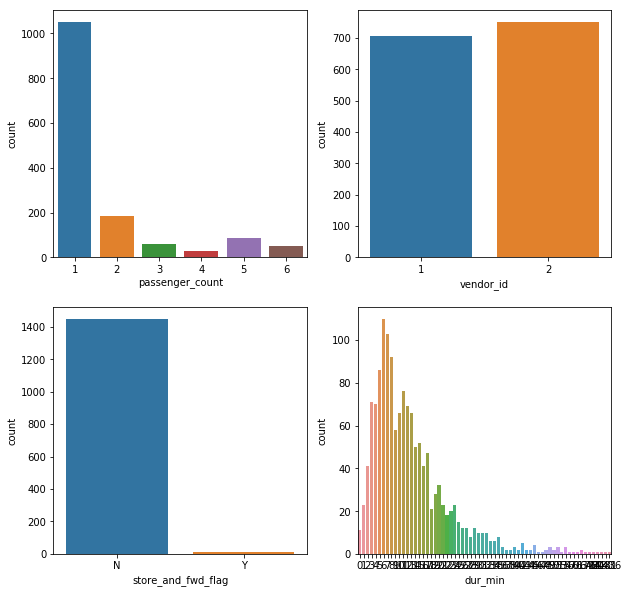

In [14]:
fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(221)
data1 = train.groupby('passenger_count').aggregate({'id':'count'}).reset_index()
sns.barplot(x='passenger_count', y='id', data=data1, ax=ax1)
plt.ylabel('count')

ax2 = fig.add_subplot(222)
data2 = train.groupby('vendor_id').aggregate({'id':'count'}).reset_index()
sns.barplot(x='vendor_id', y='id', data=data2, ax=ax2)
plt.ylabel('count')

ax3 = fig.add_subplot(223)
data3 = train.groupby('store_and_fwd_flag').aggregate({'id':'count'}).reset_index()
sns.barplot(x='store_and_fwd_flag', y='id', data=data3, ax=ax3)
plt.ylabel('count')

ax4 = fig.add_subplot(224)
data4 = train.groupby('dur_min').aggregate({'id':'count'}).reset_index()
sns.barplot(x='dur_min', y='id', data=data4, ax=ax4)
plt.ylabel('count')

# ax5 = fig.add_subplot(221)
# data5 = train.groupby('distance').aggregate({'id':'count'}).reset_index()
# sns.barplot(x='distance', y='id', data=data5, ax=ax5)
# plt.ylabel('count')


plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


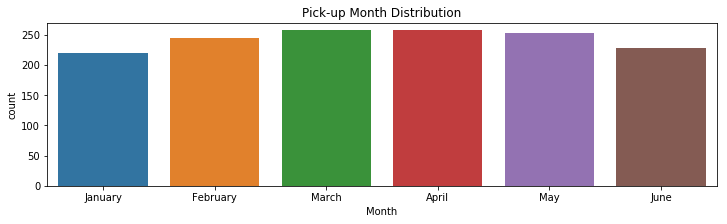

In [15]:
# 월별 Pick-up Distribution
plt.figure(figsize=(12,3))

data = train.groupby('pick_dayofmonth').aggregate({'id':'count'}).reset_index()
sns.barplot(x='pick_dayofmonth', y='id', data=data)


plt.title('Pick-up Month Distribution')
plt.xlabel('Month')
plt.xticks(range(0,6), calendar.month_name[1:7])
plt.ylabel('count')

plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


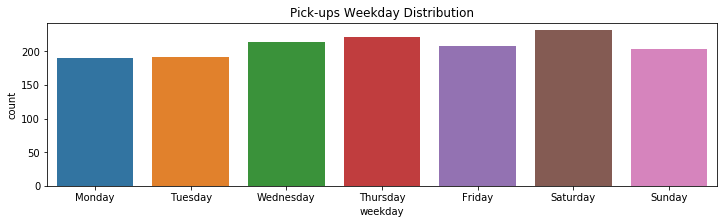

In [16]:
# 요일별 Pick-up Distribution
plt.figure(figsize=(12,3))

data = train.groupby('pick_dayofweek').aggregate({'id':'count'}).reset_index()
sns.barplot(x='pick_dayofweek', y='id', data=data)


plt.title('Pick-ups Weekday Distribution')
plt.xlabel('weekday')
plt.xticks(range(0,7), calendar.day_name[0:7])
plt.ylabel('count')

plt.show()

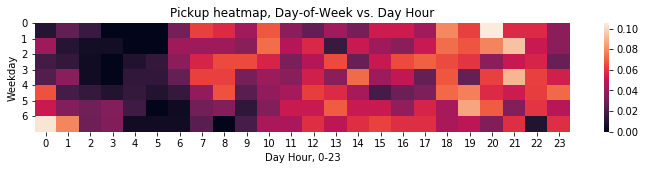

In [17]:
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(train.pick_dayofweek, 
                             train.pick_datehour, 
                             values=train.id, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), rotation='horizontal')

plt.show()

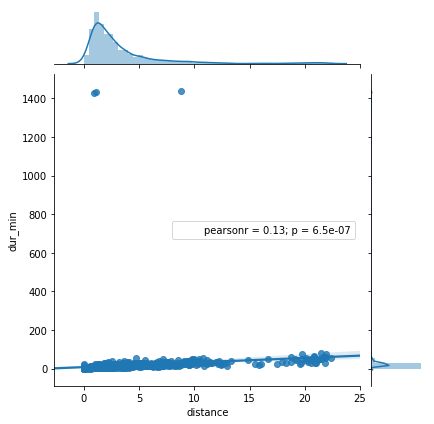

In [18]:
sns.jointplot(train['distance'], train['dur_min'], kind = 'reg') ## distance와 trip_duration의 jointplot
plt.show()

In [19]:
train.loc[train.dur_min > 300] = np.nan ##40000초(약 11시간)가 넘는 데이터 제거
train.dropna(inplace=True)

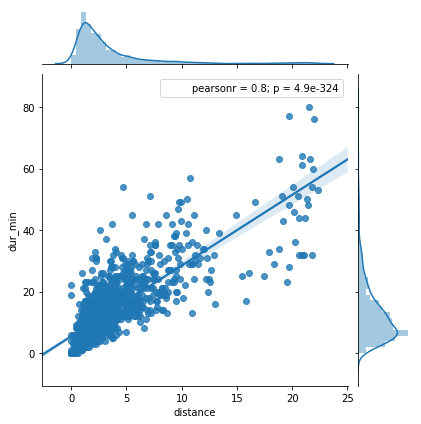

In [20]:
sns.jointplot(train['distance'], train['dur_min'], kind = 'reg') ## distance와 trip_duration의 jointplot
plt.show()

# Map Visualization

- locate data onto NYC map (pickup location)

In [21]:
# interactive map visualization
# pick location and count data on the map
#center location
center=[np.mean(train['pickup_latitude']), np.mean(train['pickup_longitude'])]

m = folium.Map(
    location = center,
    zoom_start=10)

marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)

for i in range(len(train)):
    location1=[train.iloc[i, 6], train.iloc[i, 5]]
    folium.CircleMarker(
        location=location1,
        radius=1,
        color = "blue"
      ).add_to(m)
    marker = folium.Marker(location=location1)
    marker_cluster.add_child(marker)
    marker_cluster.add_to(m)
    
m

# Draw multiple lines (test)

In [40]:
import folium
from folium.features import DivIcon

#data integration(pick + drop)
data11 = [[train.iloc[i, 6], train.iloc[i, 5]] for i in range(20)]
data22 = [[train.iloc[i, 8], train.iloc[i, 7]] for i in range(20)]

data33 = []

for i in range(20):
    data33.append(data11[i])
    data33.append(data22[i])

data33


# Create the map and add the line
m = folium.Map(location=center, zoom_start=10, tiles = "Cartodb Positron")


# icon = folium.features.DivIcon()

icon_test = folium.features.DivIcon(icon_size=(5,5))

#drop marker added
for i in range(20):
    folium.Marker(location = data22[i], 
        icon=DivIcon(
        icon_size=(5,5),
#         icon_anchor=(0,0),
        html='<div class="fa fa-automobile" style="font-size:5px"></div>',
        )
        ).add_to(m)


    
my_PolyLine=folium.PolyLine(locations=data33, color = "darkorange" ,weight=0.5)
m.add_children(my_PolyLine)

/home/jk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [23]:
import folium

# Coordinates are 10 points on the great circle from Boston to
# San Francisco.
# Reference: http://williams.best.vwh.net/avform.htm#Intermediate
data1 = [[train.iloc[i, 6], train.iloc[i, 5]] for i in range(len(train))]
data2 = [[train.iloc[i, 8], train.iloc[i, 7]] for i in range(len(train))]

data3 = []

for i in range(len(train)):
    data3.append(data1[i])
    data3.append(data2[i])

data3

# Create the map and add the line
m = folium.Map(location=center, zoom_start=10, tiles = "Cartodb Positron")
my_PolyLine=folium.PolyLine(locations=data3, color = "darkorange" ,weight=0.5)
m.add_children(my_PolyLine)
# m.save('line_example_newer.html')

/home/jk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
